In [22]:
from __future__ import division, print_function

# Set up autoreloading
# This way every time you run a block, it checks to see whether all modules
# have changed on disk and reloads them if so. You immediately see the effect
# of editing modules. Be warned that autoreloading does not affect everything:
# * Objects, once created, store the code for their methods; you'll have to 
#   recreate the objects if you want to update the code. (Workarounds exist.)
# * from module import thing results in thing not being updated on reload.
%load_ext autoreload
%autoreload 2

# Python standard library imports
import os
from glob import glob
from os.path import join
import numpy as np
# Shortcut: I use these a lot
from numpy.fft import rfft, irfft, fft, ifft


# Replace debugging print statements with debug(message)
# This way they will appear in the notebook, in pink, and
# can be left in place as they won't print unless the logger
# has been set.
import logging
from logging import debug, info, error
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


import matplotlib
matplotlib.rc("image", composite_image=False) # Works around a bug
# This sets how big plots will look on your screen
# You can change figsize, but in particular this will set how big 
# the text will be on your screen. If it's the actual number of pixels
# per inch on your monitor, then figsize will set the actual figure size
# in inches.
matplotlib.rc("savefig", dpi=144) 
# Note that there are hacks to make things nicer for those with retina screens,
# that is, screens with such high resolution that Apple decided to lie about it
# to web clients. I don't have one so can't test that. But they basically double
# the PNG resolution without doubling the on-screen size. With a recent matplotlib,
# this should work:
# %config InlineBackend.figure_format = 'retina'
# Turn on inline plotting.
%matplotlib inline
# Make plotting functions available as plt.
import matplotlib.pyplot as plt
# This sets a bunch of defaults to look a little nicer
plt.style.use("seaborn-notebook")

# Imports from other software users need to make sure to install
# Maybe numpy scipy and matplotlib should be here but what kind
# of stone-age python installation is missing those? These imports
# are here to let people know they may have to install this dependency
# just to get the notebook to work.
import psrchive

# Imports from modules accompanying this notebook
import pipe
# Be warned that reloading doesn't work on from ... import ...
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile
import template_match as tm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load in and prepare some data to plot
template = "template-work/56412.76_GBT_1400.rmset.scrunch.sm"
T = psrchive.Archive_load(template)
T.convert_state('Stokes')
T.dedisperse()
T.remove_baseline()
t_values = T.get_data()[0,0,0,:]
t_pol = T.get_data()[0,:,0,:]
# shift fundamental to zero phase
a = np.angle(np.fft.fft(t_values)[1])/(2*np.pi)
t_values = pipe.rotate_phase(t_values, -a) 
t_pol = np.array([pipe.rotate_phase(p, -a) for p in t_pol])
t_phases = np.linspace(0,1,len(t_values),endpoint=False)

In [23]:
class ApJ(object):
    """This class bundles up various things to make publication plotting easier"""
    one_column_pt = 245.3 # get this from LaTeX with using \showthe\linewidth
    two_column_pt = 511.11743 # get this from LaTeX with using \showthe\linewidth
    pts_per_inch = 72.27 # in LaTeX
    one_column = one_column_pt/pts_per_inch # inches, \includegraphics[width=\linewidth]
    one_column_plotone = 0.85*one_column # inches, width for \plotone
    two_column = two_column_pt/pts_per_inch # inches, \includegraphics[width=\linewidth]
    two_column_plotone = 0.85*two_column # inches, width for \plotone
    golden_ratio = (np.sqrt(5)+1)/2

    # Set up a style for publication plots
    # You can also put all the below in an external "style file" but I'd rather have it here
    # so it doesn't get lost; also the sizes above are useful
    style = {
        # Usetex actually runs LaTeX to render the text, so it's a little slow
        # but should match your document. If you use additional LaTeX packages to get symbols,
        # you need to find a way to make those symbols available here. I think it's possible.
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans Serif",
        "font.monospace": "Computer Modern Typewriter",
        # Font sizes. Up to you, but these are the real font sizes in real points,
        # directly comparable to those in LaTeX. ApJ dual-column uses 10pt for main
        # text, figure captions are 8pt, and the ApJ guidelines recommend a minimum of 6pt for
        # text in figures.
        "font.size": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 10, # but don't use titles
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "legend.fontsize": 8,
        # Spacings and line thicknesses.
        "axes.labelpad": 1.0,
        "lines.linewidth": 0.5,
        "axes.linewidth": 0.5,
        "legend.frameon": False,
        "lines.markersize": 7.0,
        "xtick.major.pad": 2.0,
        "ytick.major.pad": 2.0,
        "xtick.minor.pad": 2.0,
        "ytick.minor.pad": 2.0,
        "xtick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.major.width": 0.5,
        "ytick.minor.width": 0.5,
        # Aesthetic choices
        "errorbar.capsize": 0,
        "image.cmap": "viridis",
        "figure.figsize": (one_column_plotone, one_column_plotone/golden_ratio),
    }


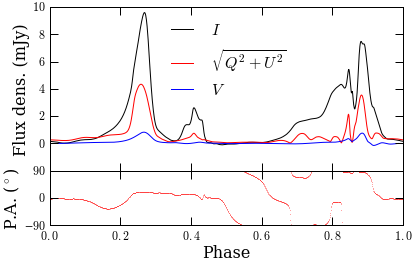

In [24]:
with plt.style.context(ApJ.style):
    # Note that these colors are chosen to match pav's polarization plots;
    # as standard as it gets.
    plt.subplot2grid((4,1),(0,0),rowspan=3)
    plt.plot(t_phases,t_pol[0],color='k', label="$I$")
    plt.plot(t_phases,np.hypot(t_pol[1],t_pol[2]),color='r',label=r"$\sqrt{Q^2+U^2}$")
    plt.plot(t_phases,t_pol[3],color='b',label="$V$")
    plt.legend(loc="best")
    # No x labels, they're shared with the PA plot
    plt.gca().tick_params("x", labelbottom="off")
    # Hide the last y tick label so it doesn't crash into the 90
    plt.gca().yaxis.get_major_ticks()[0].label.set_visible(False)
    plt.ylabel("Flux dens. (mJy)")

    # Easy way to get different-sized subplots
    plt.subplot2grid((4,1),(3,0))
    plt.plot(t_phases,np.degrees(np.arctan2(t_pol[2],t_pol[1])/2),color='r',
             linestyle="none", marker=".",markersize=0.5)
    plt.ylim(-90,90)
    plt.gca().set_yticks([-90,0,90])
    plt.xlabel("Phase")
    # The r here makes it a Python "raw string" and keeps the backslash from doing strange things.
    plt.ylabel(r"P.A. ($^\circ$)")

    # plt.tight_layout is supposed to do this but it doesn't work well with usetex or complex layouts
    # So these need to be tweaked by hand (bleagh). But with the bbox_inches hack you can tell from the
    # notebook image whether it fits.
    left=0.12
    right=0.97
    bottom=0.13
    top=0.97
    plt.subplots_adjust(hspace=0,left=left,bottom=bottom,top=top,right=right)
    # This silly hack makes the actual figure box have the golden ratio proportions
    # The enclosing figure will be made taller or shorter as needed to match.
    # Much easier to just set vert=1/golden_ratio, or use the default figsize.
    vert = ((right-left)/ApJ.golden_ratio)/(top-bottom)
    plt.gcf().set_size_inches(ApJ.one_column_plotone, ApJ.one_column_plotone*vert)

    # Normally inline figures adjust so they never cut anything off
    # but if you want control of the text size in the PDF you can't use this for the saved PDF
    # and if you're using the notebook to make the saved PDF this makes the inline match the PDF
    %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

    plt.savefig("demo-template.pdf",bbox_inches=None)


In [5]:
# Switch back on the auto-adapting of the inline figures; clipped captions
# aren't what I want from one-line plot commands. This can't go in the
# same block as the plotting, unfortunately.
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}


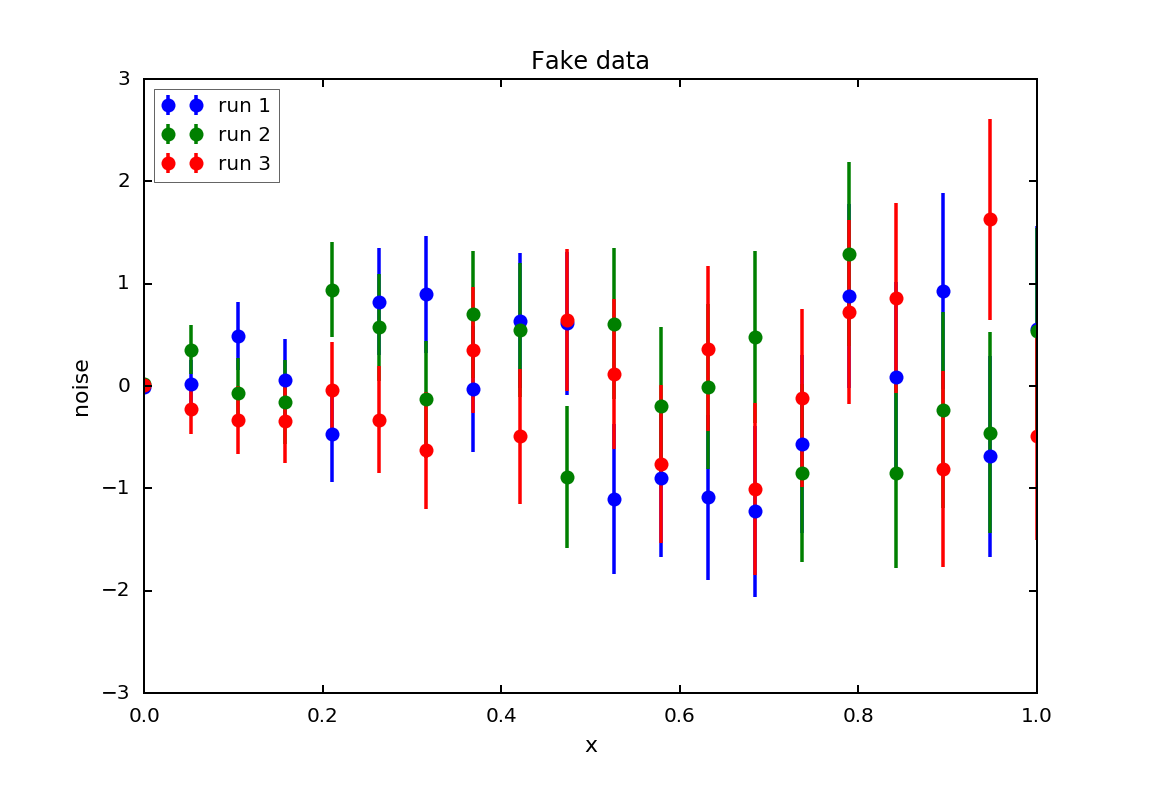

In [17]:
# For comparison, here's the non-ApJ style

xs = np.linspace(0,1,20)
errors = np.sqrt(xs)+1e-2
ys = errors*np.random.randn(len(xs))
ys2 = errors*np.random.randn(len(xs))
ys3 = errors*np.random.randn(len(xs))

plt.errorbar(xs,ys,errors,linestyle="none",marker="o", label="run 1")
plt.errorbar(xs,ys2,errors,linestyle="none",marker="o", label="run 2")
plt.errorbar(xs,ys3,errors,linestyle="none",marker="o", label="run 3")
plt.xlabel("x")
plt.ylabel("noise")
plt.title("Fake data")
plt.legend(loc="best")